In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/README
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/metadata.csv
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ004-0143.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ013-0153.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ008-0282.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ048-0113.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ009-0166.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ038-0035.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ031-0043.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ038-0120.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ011-0258.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ028-0409.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ050-0125.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ028-0062.wav
/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
# from jiwer import wer

2024-06-27 04:40:37.433653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 04:40:37.433767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 04:40:37.576739: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
wavs_path = "/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/"
metadata_path = "/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/metadata.csv"

In [11]:
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)

In [12]:
metadata_df.tail()

,0,1,2
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...
13099,LJ050-0278,the recommendations we have here suggested wou...,the recommendations we have here suggested wou...


In [13]:
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
print(metadata_df.head(3))

    file_name                           normalized_transcription
0  LJ035-0161  The reconstruction was the minimum time. Accor...
1  LJ025-0038                       carbon, hydrogen and oxygen.
2  LJ042-0060  Oswald met disappointments there just as he ha...


In [14]:
train_size = int(len(metadata_df) * 0.10)
val_size = int(len(metadata_df) * 0.01)

# Sample the DataFrame
df_train = metadata_df.sample(n=train_size, random_state=42)  # Take 10% for training
df_val = metadata_df.sample(n=val_size, random_state=42)  # Take 1% for validation

# Print the lengths of train and validation sets for verification
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")

Training set size: 1310
Validation set size: 131


In [15]:
df_train.head()

,file_name,normalized_transcription
4347,LJ011-0261,"He was found guilty of an assault with intent,..."
7732,LJ008-0252,"Another deep roar, louder than any which had p..."
3545,LJ003-0042,The completion of this very necessary building...
1237,LJ004-0224,"So plentiful was this dietary, that although t..."
720,LJ037-0124,The Commission is satisfied that the lineups w...


In [16]:
characters=[x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
char_to_num = keras.layers.StringLookup (vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(vocabulary = char_to_num.get_vocabulary(), oov_token="" ,invert = True)

In [17]:
frame_length = 256
frame_step = 160
fft_length = 384

In [18]:
def encode_single_sample(wav_file, label):
    file_path = tf.strings.join([wavs_path, wav_file, ".wav"])
    file = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    
    spectrogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    
    return spectrogram, label

In [19]:
batch_size = 32

# Assuming df_train and df_val are pandas DataFrames with columns "file_name" and "normalized_transcription"
train_dataset = tf.data.Dataset.from_tensor_slices((list(df_train["file_name"]), list(df_train["normalized_transcription"])))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((list(df_val["file_name"]), list(df_val["normalized_transcription"])))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


AttributeError: 'function' object has no attribute 'display'

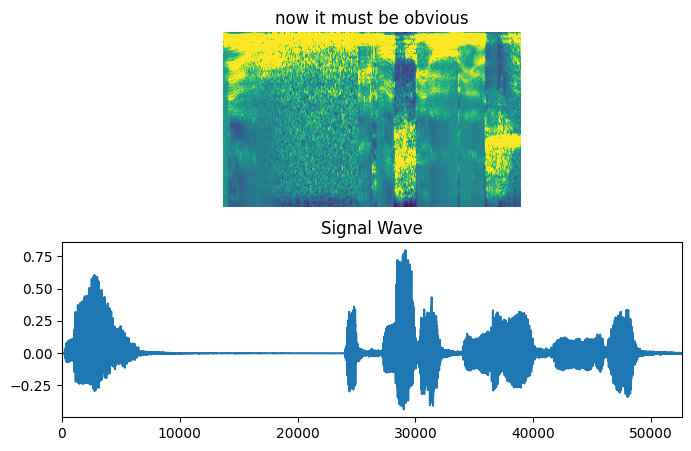

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display

fig = plt.figure(figsize=(8, 5))

for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    
    # Spectrogram
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    
    # Wav
    file = tf.io.read_file(os.path.join(wavs_path, list(df_train["file_name"])[0] + ".wav"))
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    
    display.display(Audio(np.transpose(audio), rate=16000))

plt.show()

In [20]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = tf.ones(shape=(batch_len, 1), dtype="int64") * input_length
    label_length = tf.ones(shape=(batch_len, 1), dtype="int64") * label_length

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [21]:

def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")

    # Expand the dimension to use 2D CNN
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)

    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)

    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)

    # Collapse the feature maps into 1D sequence
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    # RNN layers
    for i in range(rnn_layers):
        recurrent = layers.GRU(
            units=rnn_units,
            activation='tanh',
            recurrent_activation='sigmoid',
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i + 1}",
        )
        x = layers.Bidirectional(recurrent, name=f"bidirectional_gru_{i + 1}")(x)
        x = layers.BatchNormalization(name=f"rnn_bn_{i + 1}")(x)

    # Fully connected layer
    x = layers.Dense(units=rnn_units, name="fc")(x)
    x = layers.ReLU(name="fc_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    # Output layer
    output = layers.Dense(units=output_dim + 1, activation="softmax", name="output")(x)

    # Define the model
    model = tf.keras.Model(inputs=input_spectrogram, outputs=output, name="DeepSpeech2")
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt,loss=CTCLoss)

    return model

In [32]:

model = build_model(
input_dim = fft_length // 2 +1,
    output_dim = char_to_num.vocabulary_size(),
    rnn_units = 512,
)
model.summary()

Model: "DeepSpeech2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 193)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dim (Reshape)            │ (None, None, 193, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, None, 97, 32)   │        14,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_bn (BatchNormalization)  │ (None, None, 97, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_relu (ReLU)              │ (None, None, 97, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, None, 49, 32)   │       236,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_bn (BatchNormalization)  │ (None, None, 49, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_relu (ReLU)              │ (None, None, 49, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, None, 1568)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_gru_1             │ (None, None, 1024)     │     6,395,904 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_bn_1 (BatchNormalization)   │ (None, None, 1024)     │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_gru_2             │ (None, None, 1024)     │     4,724,736 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_bn_2 (BatchNormalization)   │ (None, None, 1024)     │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_gru_3             │ (None, None, 1024)     │     4,724,736 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_bn_3 (BatchNormalization)   │ (None, None, 1024)     │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_gru_4             │ (None, None, 1024)     │     4,724,736 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_bn_4 (BatchNormalization)   │ (None, None, 1024)     │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_gru_5             │ (None, None, 1024)     │     4,724,736 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_bn_5 (BatchNormalization)   │ (None, None, 1024)     │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, None, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_relu (ReLU)                  │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,107,776 (99.59 MB)

 Trainable params: 26,097,408 (99.55 MB)

 Non-trainable params: 10,368 (40.50 KB)

In [33]:
# Train the model
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=50)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 902s 21s/step - loss: 806.6396 - val_loss: 471.3301
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - loss: 382.7953 - val_loss: 595.9561
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - loss: 326.0233 - val_loss: 441.6557
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - loss: 304.7197 - val_loss: 458.5391
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - loss: 291.8392 - val_loss: 502.3504
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - loss: 278.6276 - val_loss: 423.7191
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - loss: 264.8983 - val_loss: 393.0576
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - loss: 252.2681 - val_loss: 329.6342
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - loss: 235.5075 - val_loss: 308.2649
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - loss: 215.8846 - val_loss: 261.1075
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - loss: 201.7901 - val_loss: 215.1865
Epoch 12/50
41/41 ━━━━━━━━━━

In [34]:
file_p = "/kaggle/working/check/"
if not os.path.exists(file_p):
    os.makedirs(file_p);
model.save_weights(file_p+"model1.weights.h5")

In [37]:
model2 = build_model(
input_dim = fft_length // 2 +1,
    output_dim = char_to_num.vocabulary_size(),
    rnn_units = 512,
)
model2.load_weights(r'/kaggle/working/check/model1.weights.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [35]:
# Define the path to check
import os
file_path = '/kaggle/working/check/model1.weights.h5'

# Check if the file exists
if os.path.exists(file_path):
    print(f"File found: {file_path}")
else:
    print(f"File not found: {file_path}")

File found: /kaggle/working/check/model1.weights.h5


In [60]:
import tensorflow as tf
from tensorflow import keras

# Define characters and StringLookup layers
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

def predict_on_dataset(model, dataset, num_samples=5):
    for batch in dataset:
        X, y = batch
        batch_predictions = model.predict(X)
        batch_predictions = tf.argmax(batch_predictions, axis=-1)  # Get predicted indices
        batch_predictions = num_to_char(batch_predictions)  # Convert indices to characters

        # Decode labels and print targets
        targets = []
        for label in y:
            label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            targets.append(label)

        # Print sample predictions
        print("-" * 100)
        for i in range(min(num_samples, len(targets))):
            # Refine prediction output: remove consecutive duplicates and excessive spaces
            predicted_text = tf.strings.reduce_join(batch_predictions[i], separator='', axis=-1).numpy().decode('utf-8')
            refined_prediction = ""
            previous_char = ""
            for char in predicted_text:
                if char != previous_char:
                    refined_prediction += char
                previous_char = char

            print(f"Target: {targets[i]}")
            print(f"Prediction: {refined_prediction.strip()}")  # Strip excess spaces
            print("-" * 100)

# Example usage:
# Assuming model2 and validation_dataset are defined
predict_on_dataset(model2, validation_dataset, num_samples=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
----------------------------------------------------------------------------------------------------
Target: he was found guilty of an assault with intent and sentenced to transportation for fourteen years
Prediction: he was found gilty of an as sault withintent and sentence to transportation for fourten years
----------------------------------------------------------------------------------------------------
Target: another deep roar louder than any which had preceded it broke from the multitude
Prediction: an other dep ror lodr than any which had preceded it broke from the mltue
----------------------------------------------------------------------------------------------------
Target: the completion of this very necessary building was however much delayed for want of funds
Prediction: the completion of this very necesary bild ing was however much delayed for want of funds
-------------------------------------------------------------------------